# Approximate cloning 

The no-cloning theorem prohibits the existence of an algorithm that can make copies of arbitrary quantum states. However, it doesn't make any statements about the (non-)existence of algorithms that can produce something that looks *close* to the original state. In this set of exercises, you will learn how to implement a continuous-variable algorithm for approximately cloning *coherent states*.

Coherent states are constructed through displacement of the vacuum state. In the Fock basis, they take the form

$$
\begin{equation}
|\alpha\rangle = D(\alpha)|0\rangle =  e^{-|\alpha|^2/2} \sum_{n=0}^\infty \frac{\alpha^n}{\sqrt{n!}} |n\rangle
\end{equation},
$$

where $\alpha$ is a complex number.

**Exercise 0.** Choose your favourite complex number and store it in the variable `alpha_0` below. This is the state we will approximately clone.

In [2]:
alpha_0 = 0.5 - 2j

The circuit for cloning uses four modes:

<img src="cloning.svg" width=500>

Our initial state, $|\alpha_0\rangle$ is input into the first mode $q_0$; following interactions with two auxiliary modes $q_1$ and $q_2$, we should wind up with approximate (identical) copies on modes $q_0$ and $q_3$. 

More specifically, the circuit performs the following:
 1. Two 50-50 beamsplitters are applied to modes $(q_0, q_1)$ and modes $(q_1, q_2)$.
 2. Mode $q_1$ undergoes homodyne measurement in $X$. The output $u$ is used to control an $X$ displacement, $X(\sqrt{2}u)$, on $q_0$. 
 3. Mode $q_2$ undergoes homodyne measurement in $P$. The output $v$ is used to control a $Z$ displacement, $Z(\sqrt{2}v)$, on $q_0$.
 4. A 50-50 beamsplitter is applied between modes $(q_0, q_3)$.

Let's implement this circuit, and see what we get!

**Exercise 1.** Implement the above circuit as a program in Strawberry Fields.

If you're not sure what operations to use, head over to the [documentation](https://strawberryfields.readthedocs.io/en/stable/introduction/ops.html), where there is a nice list of operations and measurements. The [guide on creating circuits in Strawberry Fields](https://strawberryfields.readthedocs.io/en/stable/introduction/circuits.html) will also be helpful, in particular for the controlled operations.

In [3]:
import strawberryfields as sf
from strawberryfields.ops import *
import numpy as np

gaussian_cloning = sf.Program(4)

with gaussian_cloning.context as q:
    # state to be cloned
    Coherent(np.abs(alpha_0), np.angle(alpha_0)) | q[0]

    # 50-50 beamsplitter
    BS = BSgate(np.pi/4, 0)

    # symmetric Gaussian cloning scheme
    BS | (q[0], q[1])
    BS | (q[1], q[2])
    MeasureX | q[1]
    MeasureP | q[2]
    Xgate(q[1].par * np.sqrt(2)) | q[0]
    Zgate(q[2].par * np.sqrt(2)) | q[0]

    # after the final beamsplitter, modes q[0] and q[3]
    # will contain identical approximate clones of the
    # initial state Coherent(0.1+0j)
    BS | (q[0], q[3])

**Exercise 2.** Run your proram using the Gaussian backend, and extract the results on mode $q_0$ (or mode $q_3$; they should produce identical results!). 

*Hint*: Investigate the [documentation of the `run` method](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.Engine.html#strawberryfields.Engine.run) to determine how to obtain results for a subset of modes.

In [13]:
eng = sf.Engine(backend="gaussian")
results = eng.run(gaussian_cloning, modes=[0])

**Exercise 3.** Using the `state` attribute of your results, compute the fidelity between the state you obtained, and your original coherent state. The method [`fidelity_coherent`](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.backends.BaseState.html#strawberryfields.backends.BaseState.fidelity_coherent) can be called using the state of your results. How high is the fidelity?

In [14]:
fidelity = results.state.fidelity_coherent([alpha_0])
print(fidelity)

0.9280188565421659


**Exercise 4.** If you ran this a few times, you may have noticed that the results are probabilistic. Run the experiment 1000 times, and plot the distribution of fidelities; how does it look? What is the average fidelity?

In [15]:
reps = 1000
f = np.empty([reps])

for i in range(reps):
    eng.reset()
    results = eng.run(gaussian_cloning, modes=[0])
    f[i] = results.state.fidelity_coherent([alpha_0])

(array([ 14.,  35.,  67.,  73.,  92.,  98., 116., 145., 180., 180.]),
 array([0.02145064, 0.11920228, 0.21695393, 0.31470558, 0.41245722,
        0.51020887, 0.60796052, 0.70571216, 0.80346381, 0.90121546,
        0.9989671 ]),
 <BarContainer object of 10 artists>)

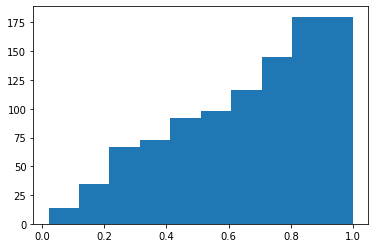

In [16]:
import matplotlib.pyplot as plt
plt.hist(f)

**Exercise 5.** The `state` attribute of the program results also allows you to  extract the $\alpha$ of the output coherent state (the [displacement](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.backends.BaseGaussianState.html#strawberryfields.backends.BaseGaussianState.displacement)). Run the program again 1000 times, and this time extract the displacement from each. Plot the real and complex valued parts of the resuls. What is the distribution, and how does it relate to your original $\alpha_0$?

In [18]:
reps = 1000
a = np.empty([reps], dtype=np.complex64)

for i in range(reps):
    eng.reset()
    results = eng.run(gaussian_cloning, modes=[0])
    a[i] = results.state.displacement()

(array([  3.,  12.,  53., 133., 228., 264., 184.,  78.,  36.,   9.]),
 array([-1.2290835 , -0.8959639 , -0.5628442 , -0.22972457,  0.10339508,
         0.43651474,  0.76963437,  1.102754  ,  1.4358737 ,  1.7689934 ,
         2.102113  ], dtype=float32),
 <BarContainer object of 10 artists>)

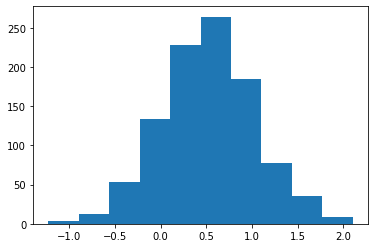

In [19]:
plt.hist(a.real)

(array([  1.,   2.,  17.,  77., 224., 278., 253., 119.,  24.,   5.]),
 array([-4.0986547 , -3.7263393 , -3.354024  , -2.9817088 , -2.6093934 ,
        -2.237078  , -1.8647625 , -1.4924473 , -1.1201319 , -0.7478165 ,
        -0.37550113], dtype=float32),
 <BarContainer object of 10 artists>)

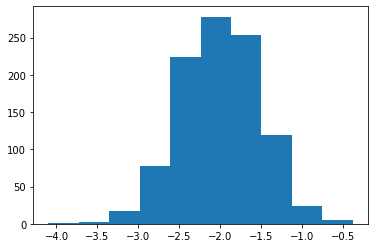

In [21]:
plt.hist(a.imag)